<a href="https://colab.research.google.com/github/darshan1328/180DC_work/blob/main/Aerodynamic_Optimization_using_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install neuralfoil


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 11.3 MB/s eta 0:00:00


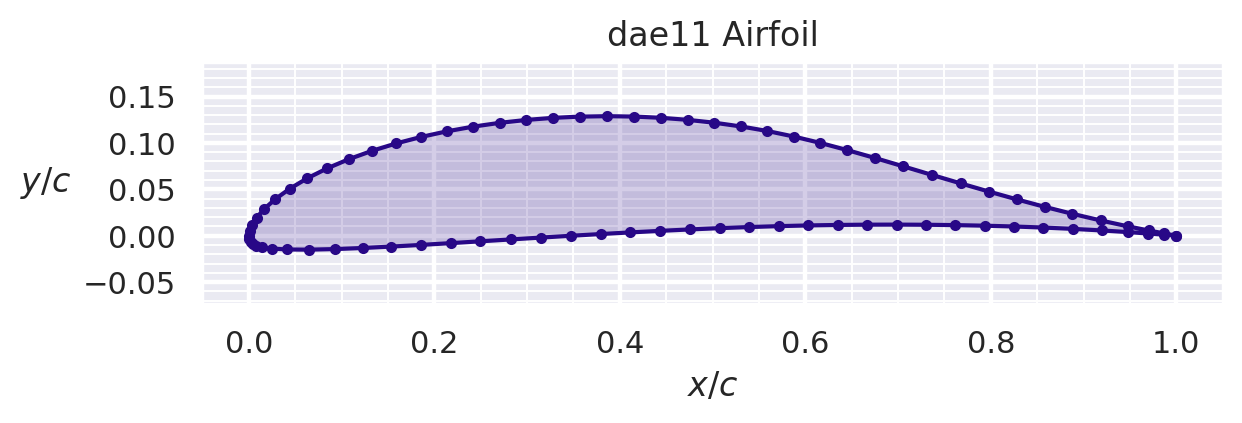

In [2]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

af = asb.Airfoil("dae11")

fig, ax = plt.subplots(figsize=(6, 2))
af.draw()

In [3]:
af.get_aero_from_neuralfoil(
    alpha=90,
    Re=1e6,
    mach=0.3,
)

{'analysis_confidence': array([5.56268465e-308]),
 'CL': array([0.09368104]),
 'CD': array([2.08466908]),
 'CM': array([-0.52116727]),
 'Cpmin': array([-1.56135107]),
 'Top_Xtr': array([2.06115364e-09]),
 'Bot_Xtr': array([1.]),
 'mach_crit': array([0.51182441]),
 'mach_dd': array([0.57968485]),
 'Cpmin_0': array([-1.5]),
 'upper_bl_theta_0': array([5.56003184e-06]),
 'upper_bl_theta_1': array([1.85121073e-05]),
 'upper_bl_theta_2': array([2.3940047e-05]),
 'upper_bl_theta_3': array([2.44449507e-05]),
 'upper_bl_theta_4': array([2.45835079e-05]),
 'upper_bl_theta_5': array([2.45892689e-05]),
 'upper_bl_theta_6': array([2.55999083e-05]),
 'upper_bl_theta_7': array([2.76076048e-05]),
 'upper_bl_theta_8': array([3.0568874e-05]),
 'upper_bl_theta_9': array([3.40513056e-05]),
 'upper_bl_theta_10': array([3.69103819e-05]),
 'upper_bl_theta_11': array([3.91550394e-05]),
 'upper_bl_theta_12': array([4.1503576e-05]),
 'upper_bl_theta_13': array([4.41731958e-05]),
 'upper_bl_theta_14': array([4.

In [4]:
results = af.get_aero_from_neuralfoil(
    alpha=90,
    Re=1e6,
    mach=0.3,
)

CL = results['CL']
CD = results['CD']
print(CL)
print(CD)

[0.09368104]
[2.08466908]


In [5]:
import pandas as pd
import numpy as np

# Define your ranges
angles = np.linspace(-20, 90, 30)        # 10 values from 0° to 90°
mach_numbers = np.linspace(0.05, 0.95, 30)  # 10 values from 0.05 to <1

# Create an empty list to store results
data = []

# Loop through combinations
for alpha in angles:
    for mach in mach_numbers:
        # Run simulation (fill this with your actual call)
        results = af.get_aero_from_neuralfoil(
            alpha=alpha,
            Re=1e6,
            mach=mach
        )

        # Extract values
        CL = results.get('CL', [None])[0]
        CD = results.get('CD', [None])[0]
        Cp = results.get('Cpmin', [None])[0]  # Use Cpmin or whatever field you want

        # Append to dataset
        data.append({
            'Alpha': alpha,
            'Mach': mach,
            'CL': CL,
            'CD': CD,
            'Cp': Cp
        })

# Convert to DataFrame and save
df = pd.DataFrame(data)
df.to_csv('neuralfoil_simulated_dataset.csv', index=False)


In [6]:
df

,Alpha,Mach,CL,CD,Cp
0,-20.0,0.050000,-0.661725,0.278777,-1.120464
1,-20.0,0.081034,-0.663017,0.278777,-1.122651
2,-20.0,0.112069,-0.664932,0.278777,-1.125894
3,-20.0,0.143103,-0.667486,0.278777,-1.130219
4,-20.0,0.174138,-0.670699,0.278777,-1.135658
...,...,...,...,...,...
895,90.0,0.825862,0.068987,2.248880,-2.257468
896,90.0,0.856897,0.072263,2.264408,-2.331004
897,90.0,0.887931,0.076218,2.274151,-2.401727
898,90.0,0.918966,0.080982,2.277572,-2.464738


In [7]:
import matplotlib.pyplot as plt


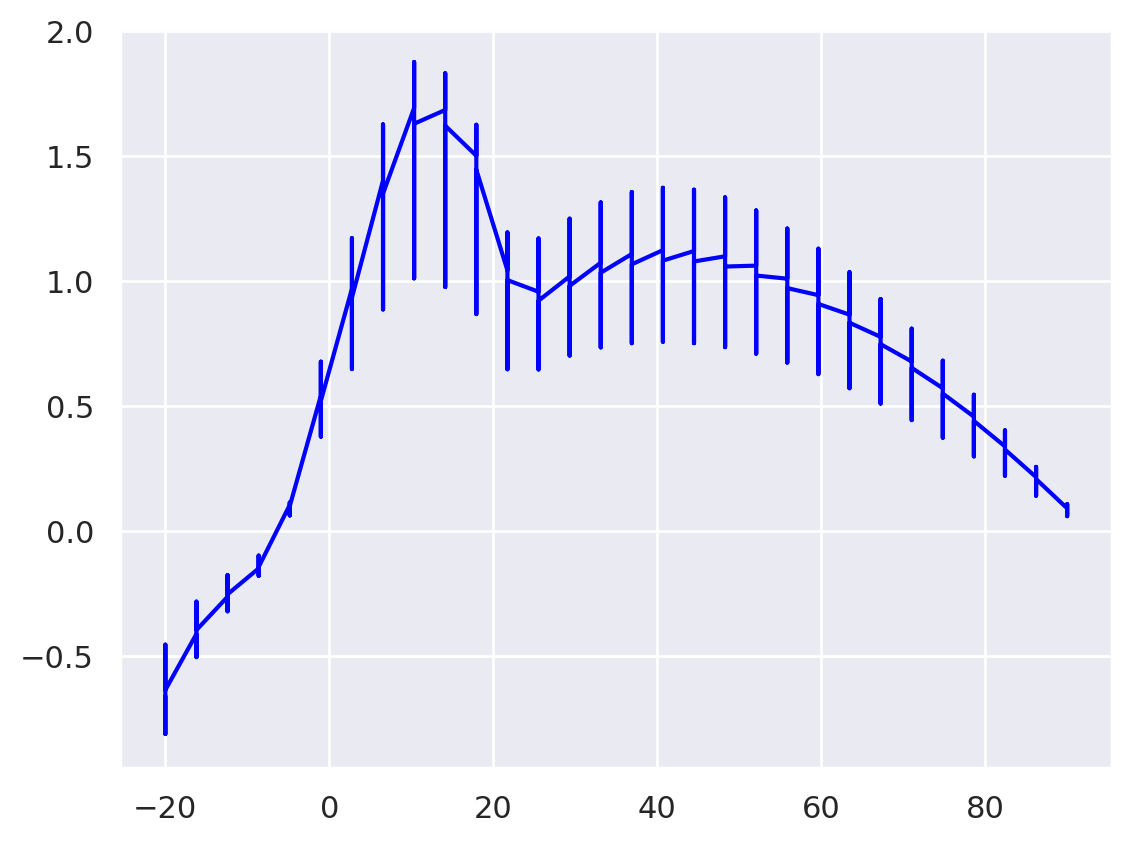

In [8]:
plt.plot(df['Alpha'], df['CL'],color='blue')

In [9]:
df.head()

,Alpha,Mach,CL,CD,Cp
0,-20.0,0.050000,-0.661725,0.278777,-1.120464
1,-20.0,0.081034,-0.663017,0.278777,-1.122651
2,-20.0,0.112069,-0.664932,0.278777,-1.125894
3,-20.0,0.143103,-0.667486,0.278777,-1.130219
4,-20.0,0.174138,-0.670699,0.278777,-1.135658


In [10]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

In [11]:
X = df[['Alpha', 'Mach']].values
Y = df[['CL', 'CD', 'Cp']].values

In [12]:
from logging import logProcesses
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
val_scores = []
for train_index, val_index in kf.split(X):

  X_train, X_value = X[train_index], X[val_index]
  Y_train, Y_value = Y[train_index], Y[val_index]

  model = models.Sequential([
      layers.Dense(64, activation='relu', input_shape=(2,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(3)
  ])

  model.compile(optimizer='adam', loss='mse', metrics=['mae'])

  model.fit(X_train, Y_train, epochs=100, batch_size=16, verbose=0)
  val_mse, val_mae = model.evaluate(X_value, Y_value, verbose=0)
  val_scores.append(val_mae)
  print(f"Fold {fold} - Validation MAE: {val_mae}")
  fold += 1



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation MAE: 0.12163346260786057
Fold 2 - Validation MAE: 0.13491246104240417
Fold 3 - Validation MAE: 0.11234062910079956
Fold 4 - Validation MAE: 0.12475211173295975
Fold 5 - Validation MAE: 0.10748082399368286


In [13]:
print("MAE per fold:", val_scores)
print("Mean MAE:", np.mean(val_scores))
print("Std MAE:", np.std(val_scores))

MAE per fold: [0.12163346260786057, 0.13491246104240417, 0.11234062910079956, 0.12475211173295975, 0.10748082399368286]
Mean MAE: 0.12022389769554138
Std MAE: 0.00962057524177589


In [14]:
!pip install scikeras

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models, layers
from sklearn.preprocessing import StandardScaler

In [15]:
def build_model(n_layers=2, n_neurons=64, optimizer='adam'):
    model = models.Sequential()
    model.add(layers.Input(shape=(2,)))  # Alpha, Mach

    for _ in range(n_layers):
        model.add(layers.Dense(n_neurons, activation='relu'))

    model.add(layers.Dense(3))  # Output: CL, CD, Cp

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [16]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Feature scaling


In [17]:
regressor = KerasRegressor(model=build_model, verbose=0)


In [18]:
param_grid = {
    "model__n_layers": [1, 2, 3],
    "model__n_neurons": [32, 64, 128],
    "model__optimizer": ['adam', 'rmsprop'],
    "batch_size": [16, 32],
    "epochs": [50, 100]
}


In [19]:
grid = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid.fit(X_scaled, Y)  # X_scaled already normalized

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models, layers
import numpy as np

# 1. Define model-building function
def build_model(n_layers=1, n_neurons=32, optimizer='adam'):
    model = models.Sequential()
    model.add(layers.Input(shape=(X.shape[1],)))

    for _ in range(n_layers):
        model.add(layers.Dense(n_neurons, activation='relu'))

    model.add(layers.Dense(3))  # Output layer (CL, CD, Cp)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# 2. Wrap it in KerasRegressor
regressor = KerasRegressor(model=build_model, verbose=0)

# 3. Define small param grid
param_grid = {
    'model__n_layers': [1, 2],
    'model__n_neurons': [32, 64],
    'batch_size': [16],
    'epochs': [60],
    'model__optimizer': ['adam']
}

# 4. GridSearchCV setup
grid = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=2,  # Fast cross-validation
    verbose=1
)

# 5. Fit to scaled data (this may take 2–5 minutes depending on CPU)
grid.fit(X_scaled, Y)

# 6. Show best result
print("Best MAE: ", -grid.best_score_)
print("Best Params:", grid.best_params_)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [20]:
final_model = build_model(n_layers=2, n_neurons=64, optimizer='adam')
final_model.fit(X_train, Y_train, epochs=60, batch_size=16, verbose=1)


Epoch 1/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 30.6222 - mae: 3.3521    
Epoch 2/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0553 - mae: 0.6104 
Epoch 3/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8933 - mae: 0.5310 
Epoch 4/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6205 - mae: 0.4261
Epoch 5/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4514 - mae: 0.3692 
Epoch 6/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3778 - mae: 0.3543 
Epoch 7/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3662 - mae: 0.3571
Epoch 8/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2681 - mae: 0.3164 
Epoch 9/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2870 - mae: 0.3297
Epoch 10/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2420 - mae: 0.3085 
Epoch 11/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2473 - mae: 0.3104
Epoch 12/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2530 - mae: 0.3213 
Epoch 13/60
45/45 ━━━━━━━━━━━━━━━━━━━

In [ ]:
model.evaluate(X_value, Y_value)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0176 - mae: 0.0924 


[0.02433684654533863, 0.11138363927602768]

In [21]:
import aerosandbox as asb
import aerosandbox.numpy as np

af = asb.Airfoil("dae11")

results = af.get_aero_from_neuralfoil(
    alpha=45,
    Re=1e6,
    mach=0.3,
)

cl_value = results['CL']
cd_value = results['CD']
cpmin_value = results['Cpmin']

print(f"CL: {cl_value}")
print(f"CD: {cd_value}")
print(f"Cpmin: {cpmin_value}")
print(f"CL/CD: {cl_value[0]/cd_value[0]}")

CL: [1.16698144]
CD: [1.22565626]
Cpmin: [-1.30112599]
CL/CD: 0.9521278285903471


In [22]:
model.predict(np.array([[45, 0.3]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


array([[ 1.0170581,  1.2265484, -1.2380757]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


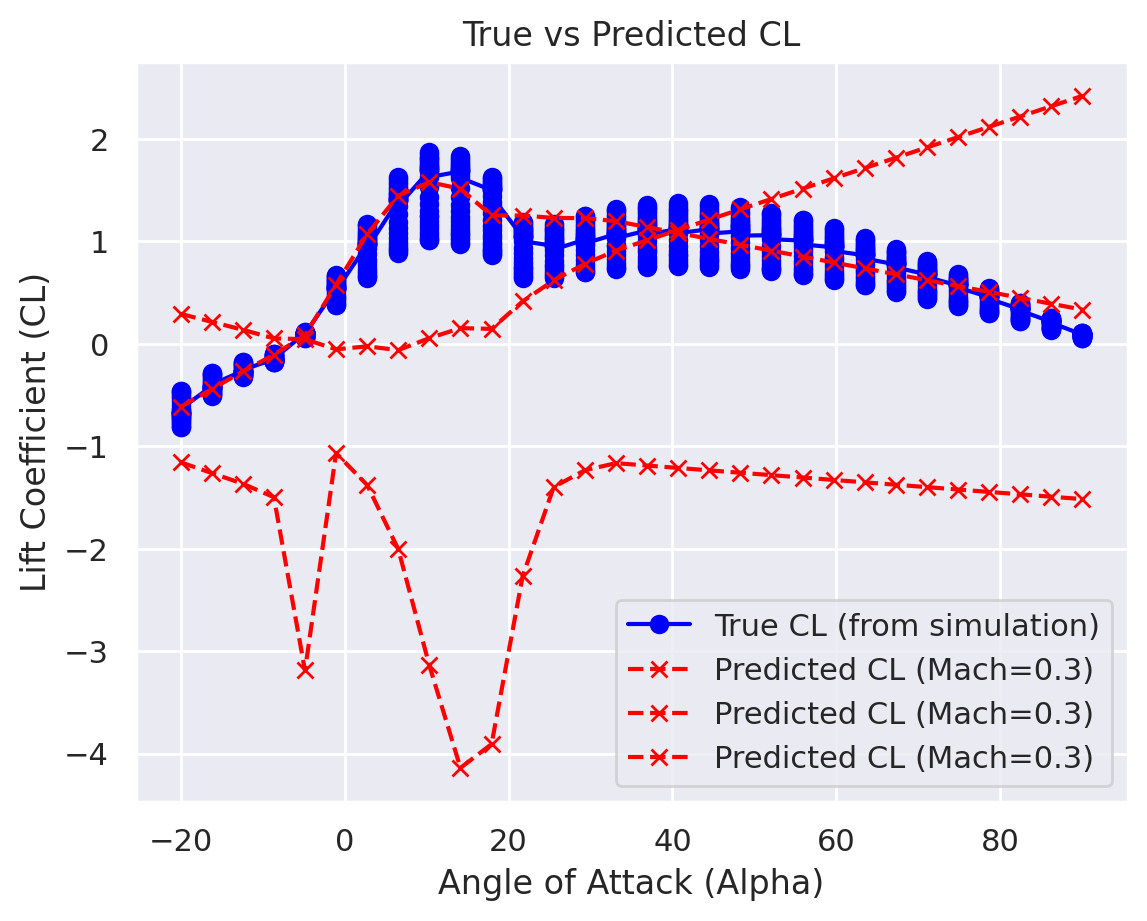

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Plot original data
plt.plot(df['Alpha'], df['CL'], label='True CL (from simulation)', color='blue', linestyle='-', marker='o')

# Generate predictions for same Alpha values at a fixed Mach number, e.g., 0.3
mach_fixed = 0.3
X_pred = np.array([[alpha, mach_fixed] for alpha in df['Alpha'].unique()])
CL_pred = model.predict(X_pred)

# Sort for clean plot (in case Alpha isn't sorted)
X_sorted = X_pred[np.argsort(X_pred[:, 0])]
CL_sorted = CL_pred[np.argsort(X_pred[:, 0])]

# Plot predicted CL
plt.plot(X_sorted[:, 0], CL_sorted, label=f'Predicted CL (Mach={mach_fixed})', color='red', linestyle='--', marker='x')

# Labeling
plt.xlabel('Angle of Attack (Alpha)')
plt.ylabel('Lift Coefficient (CL)')
plt.title('True vs Predicted CL')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


ValueError: x and y must have same first dimension, but have shapes (30,) and (90,)

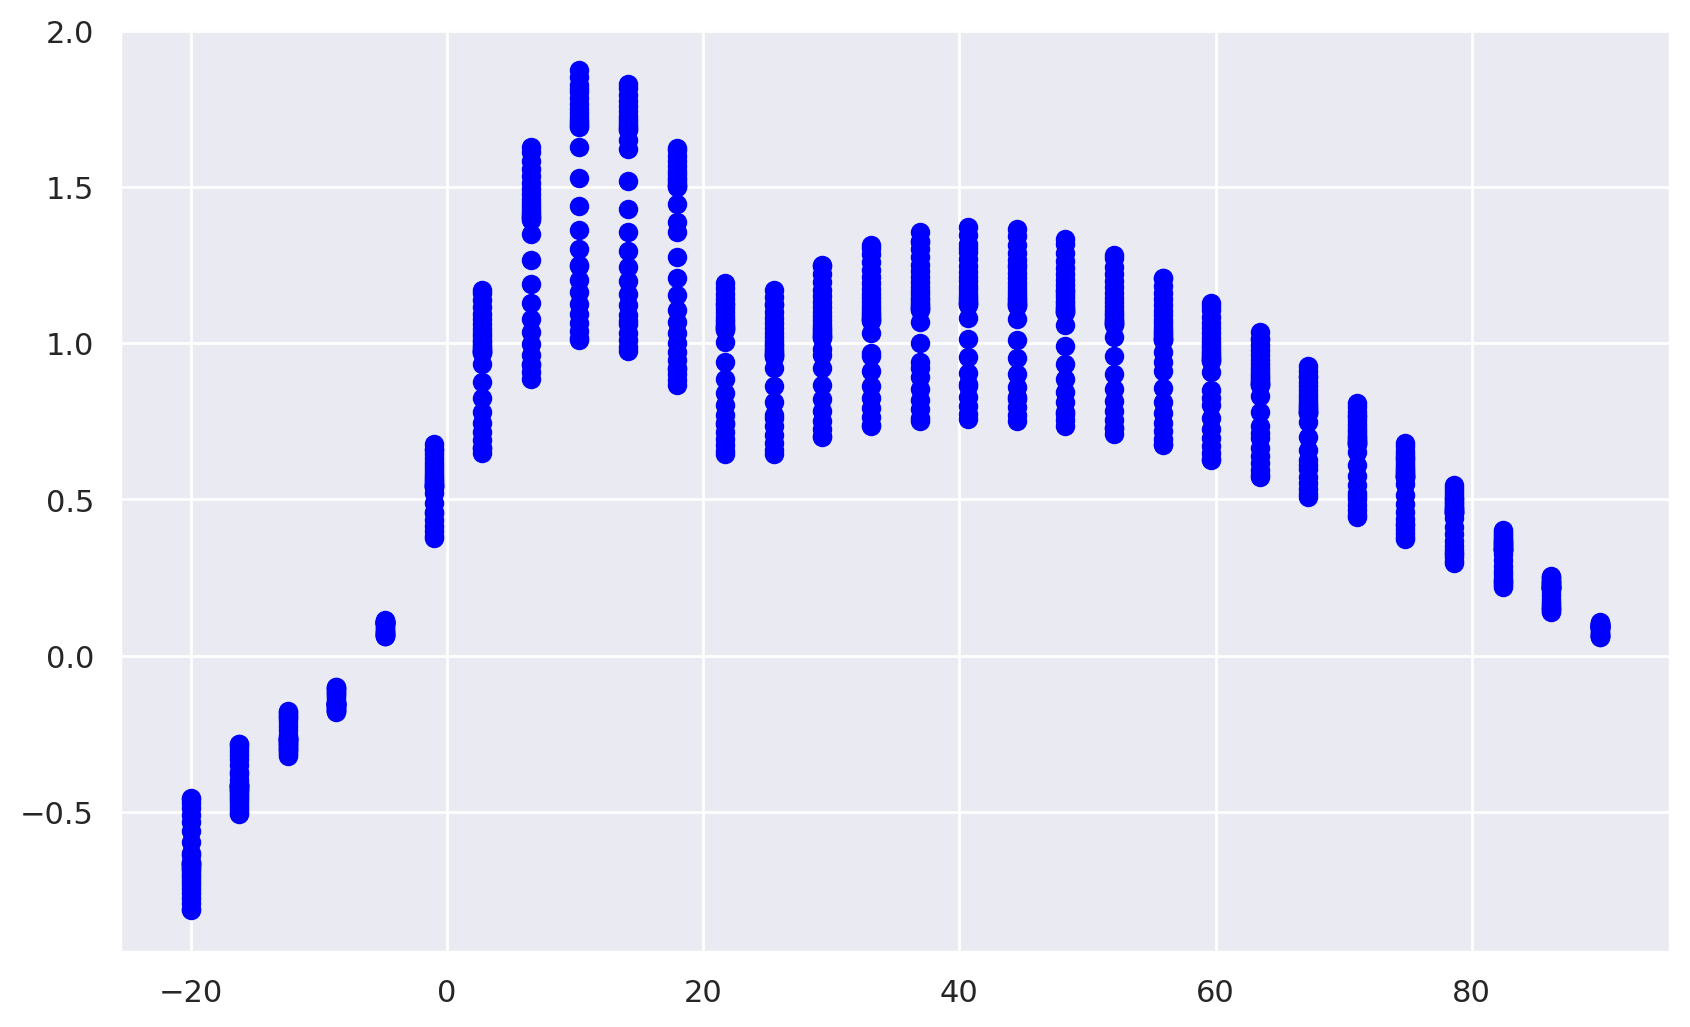

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Clear any existing plot (important in notebooks)
plt.figure(figsize=(10, 6))

# Plot the true CL values (from df)
plt.plot(df['Alpha'], df['CL'], 'o', label='True CL (from simulation)', color='blue')

# Prepare input for predictions (fixed Mach)
mach_fixed = 0.3
alphas = np.sort(df['Alpha'].unique())
X_pred = np.array([[alpha, mach_fixed] for alpha in alphas])
CL_pred = model.predict(X_pred).flatten()

# Plot predicted CL
plt.plot(alphas, CL_pred, 'x--', label=f'Predicted CL (Mach={mach_fixed})', color='red')

# Labels and formatting
plt.xlabel('Angle of Attack (Alpha)')
plt.ylabel('Lift Coefficient (CL)')
plt.title('True vs Predicted CL')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


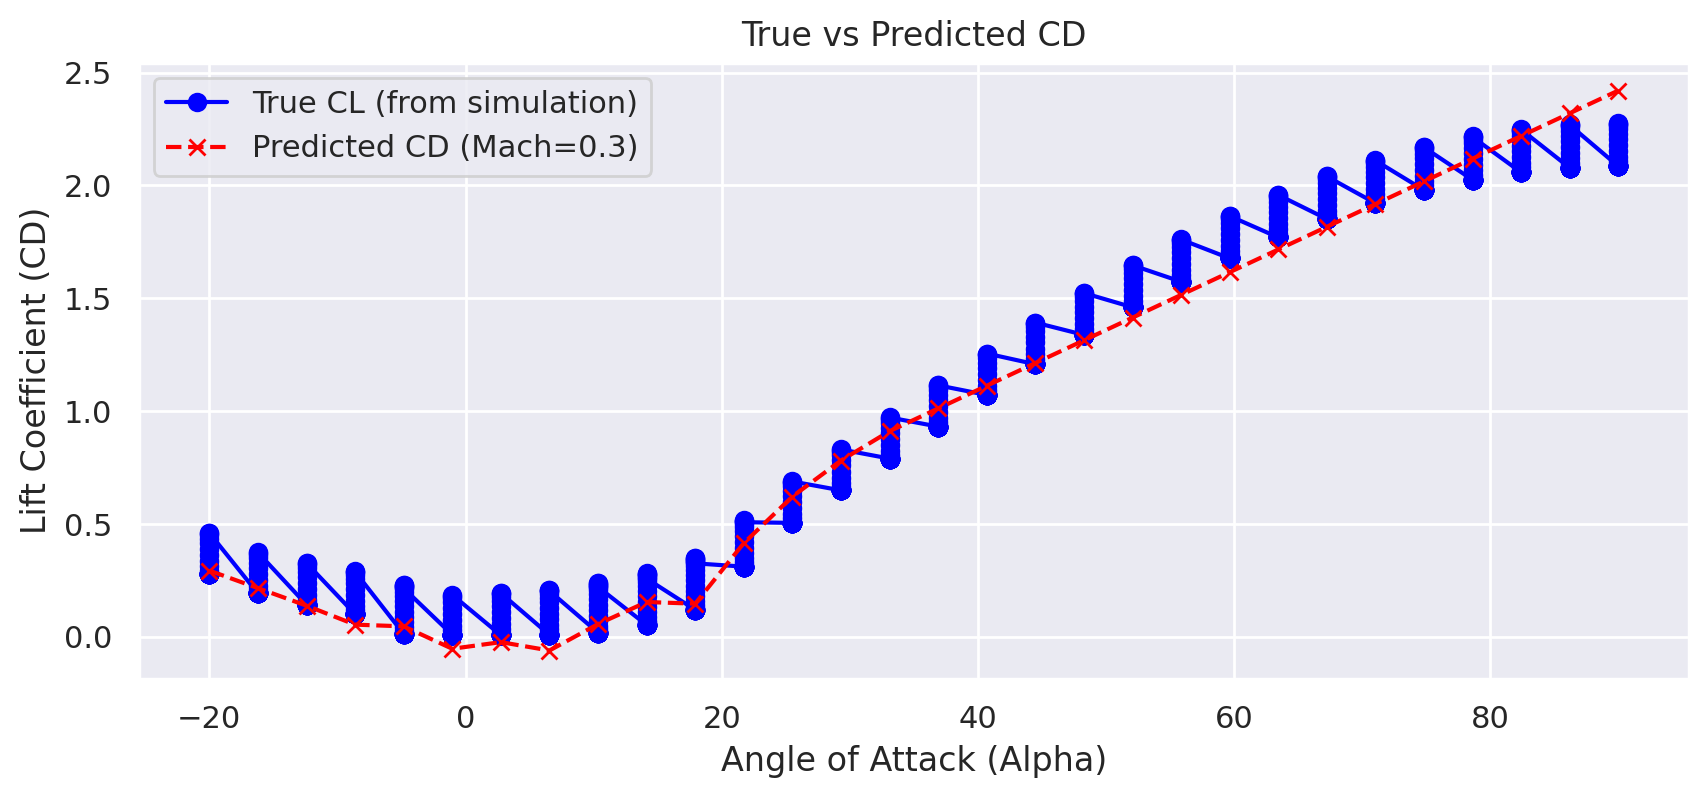

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 4))
# Plot original data
plt.plot(df['Alpha'], df['CD'], label='True CL (from simulation)', color='blue', linestyle='-', marker='o')

# Generate predictions for same Alpha values at a fixed Mach number, e.g., 0.3
mach_fixed = 0.3
alphas = np.sort(df['Alpha'].unique())
X_pred = np.array([[alpha, mach_fixed] for alpha in alphas])
CL_pred = model.predict(X_pred)[:, 1]  # Only take CD

# Plot predicted CL
plt.plot(alphas, CL_pred, label=f'Predicted CD (Mach={mach_fixed})', color='red', linestyle='--', marker='x')

# Labeling
plt.xlabel('Angle of Attack (Alpha)')
plt.ylabel('Lift Coefficient (CD)')
plt.title('True vs Predicted CD')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


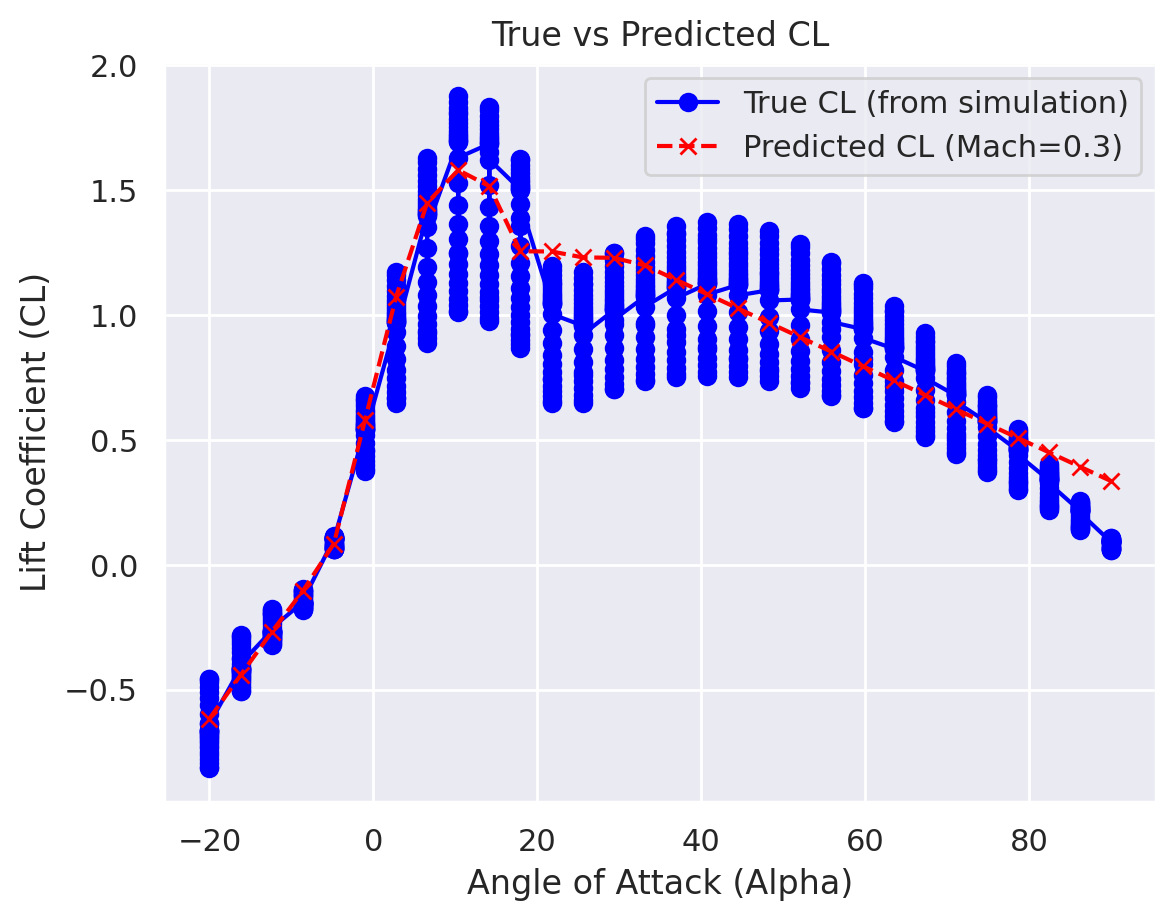

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Plot original data
plt.plot(df['Alpha'], df['CL'], label='True CL (from simulation)', color='blue', linestyle='-', marker='o')

# Generate predictions for same Alpha values at a fixed Mach number, e.g., 0.3
mach_fixed = 0.3
alphas = np.sort(df['Alpha'].unique())
X_pred = np.array([[alpha, mach_fixed] for alpha in alphas])
CL_pred = model.predict(X_pred)[:, 0]  # Only take CL

# Plot predicted CL
plt.plot(alphas, CL_pred, label=f'Predicted CL (Mach={mach_fixed})', color='red', linestyle='--', marker='x')

# Labeling
plt.xlabel('Angle of Attack (Alpha)')
plt.ylabel('Lift Coefficient (CL)')
plt.title('True vs Predicted CL')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
import pandas as pd
import numpy as np

def get_best_params(angles, velocities):

    # Ensure inputs are numpy arrays
    angles = np.array(angles)
    velocities = np.array(velocities)

    # Validate Mach numbers
    if np.any(velocities >= 1):
        raise ValueError("All Mach numbers must be less than 1.")

    # Create parameter combinations
    param_grid = np.array([[alpha, mach] for alpha in angles for mach in velocities])

    # Predict using model
    predictions = model.predict(param_grid)
    CL = predictions[:, 0]
    CD = predictions[:, 1]

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        cl_cd_ratio = np.where(CD != 0, CL / CD, np.nan)

    # Create DataFrame
    result_df = pd.DataFrame(param_grid, columns=['Alpha', 'Mach'])
    result_df['CL'] = CL
    result_df['CD'] = CD
    result_df['CL/CD'] = cl_cd_ratio

    # Sort by highest CL/CD
    result_df = result_df.sort_values(by='CL/CD', ascending=False).reset_index(drop=True)

    return result_df


In [35]:
get_best_params([0, 45, 90], [0.05, 0.3, 0.95])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


,Alpha,Mach,CL,CD,CL/CD
0,0.0,0.95,0.604569,0.160041,3.777588
1,45.0,0.05,1.078600,1.166372,0.924748
2,45.0,0.30,1.017059,1.226548,0.829205
3,45.0,0.95,0.857048,1.383004,0.619700
4,90.0,0.05,0.395488,2.360673,0.167532
5,90.0,0.30,0.333943,2.420849,0.137945
6,90.0,0.95,0.173935,2.577305,0.067487
7,0.0,0.05,0.822961,-0.091409,-9.003045
8,0.0,0.30,0.763310,-0.008389,-90.985458


In [40]:
af = asb.Airfoil("dae11")

results = af.get_aero_from_neuralfoil(
    alpha=90,
    Re=1e6,
    mach=0.3,
)

cl_value = results['CL']
cd_value = results['CD']
cpmin_value = results['Cpmin']

print(f"CL: {cl_value}")
print(f"CD: {cd_value}")
print(f"Cpmin: {cpmin_value}")
print(f"CL/CD: {cl_value[0]/cd_value[0]}")

CL: [0.09368104]
CD: [2.08466908]
Cpmin: [-1.56135107]
CL/CD: 0.044938084617862355
